In [1]:
import pickle
from pathlib import Path
import os
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
OUTPUT_DIR = Path("./outputs")
output_files = os.listdir(OUTPUT_DIR)

In [3]:
model_names = {
    "gemma-3-4b-it": "Gemma 3 4B",
    "gemma-3-12b-it": "Gemma 3 12B",
    "gemma-3-27b-it": "Gemma 3 27B"
}

In [4]:
def get_dataset_metrics(dataset_name):
    dataset_files = [file for file in output_files if file.startswith(dataset_name)]
    dataset_files = sorted(dataset_files, key=lambda x: int(x.split("_")[1].split("-")[2][:-1]))
    
    dataset_metrics = {}
    for dataset_file in dataset_files:
        model_name = dataset_file.split(".")[0].split("_")[1]
        lfw_path = OUTPUT_DIR / dataset_file
        with open(lfw_path, "rb") as f:
            dataset_metrics[model_name] = pickle.load(f)
    
    return dataset_metrics

## LFW

In [5]:
lfw_df = pd.read_csv("datasets/lfw/pairs.csv")

In [6]:
lfw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        6000 non-null   object 
 1   imagenum1   6000 non-null   int64  
 2   imagenum2   6000 non-null   object 
 3   Unnamed: 3  3000 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 187.6+ KB


In [7]:
lfw_metrics = get_dataset_metrics("lfw")

In [8]:
lfw_table_data = []
for model_name, metrics in lfw_metrics.items():
    lfw_table_data.append({
        "Model": model_names[model_name],
        "EER (%)": metrics["eer"] * 100,
        "AUC": metrics["auc"],
        "Acc. @ EER (%)": metrics["accuracy_at_eer"],
        "FAR @ EER (%)": metrics["far_at_eer"],
        "FRR @ EER (%)": metrics["frr_at_eer"],
    })

In [9]:
lfw_performance = pd.DataFrame(lfw_table_data).set_index("Model")
print(lfw_performance.to_string(float_format="%.2f"))

             EER (%)  AUC  Acc. @ EER (%)  FAR @ EER (%)  FRR @ EER (%)
Model                                                                  
Gemma 3 4B      8.55 0.97           91.45           8.53           8.57
Gemma 3 12B     4.63 0.99           95.37           4.60           4.67
Gemma 3 27B     4.07 0.99           95.93           4.00           4.13


Accuracy of best model: 99.83 from ArcFace: Additive Angular Margin Loss for Deep Face Recognition CVPR 2019  ·  Jiankang Deng, Jia Guo, Jing Yang, Niannan Xue, Irene Kotsia, Stefanos Zafeiriou

In the Face Verification task, using the LFW benchmark, we get high performance, especially with larger models. The best zero-shot performance by Gemma 3 27B is comparable to state-of-the art models (the best model at the moment has 99.83 of accuracy). This is promising especially beacause we are in a zero-shot setting, while the state-of-the-art model is an ad-hoc deep CNN. 

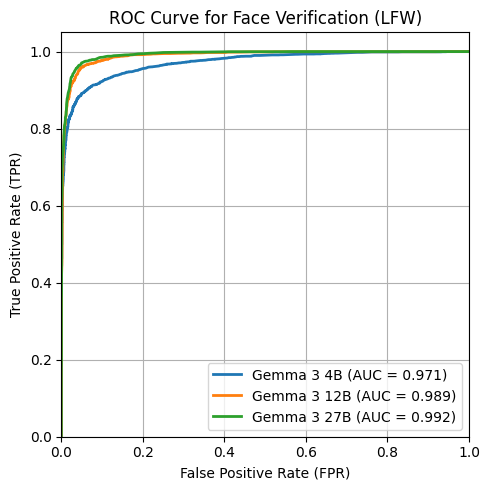

In [10]:
plt.figure(figsize=(5, 5))
for model_name, metrics in lfw_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    auc = metrics["auc"]
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[model_name]} (AUC = {auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Face Verification (LFW)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve confirms what has been previously commented (the higher the curve, the better). The best model is indeed very close to 1, meaning that it reaches high values for true positive without sacrificing too much on the false positives.

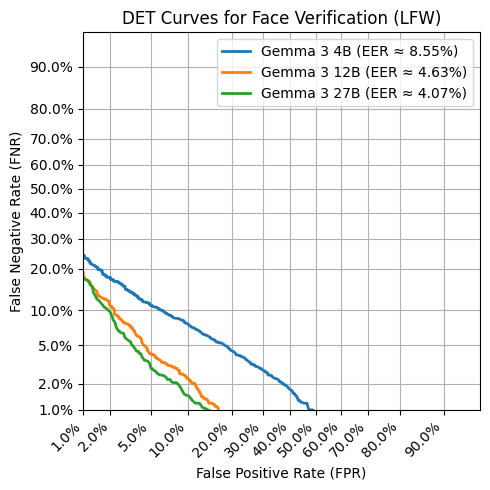

In [11]:
plt.figure(figsize=(5, 5))

# Define tick positions for DET curve (probabilities)
det_ticks_prob = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
det_ticks_nd = norm.ppf(det_ticks_prob) # Convert to Normal Deviate Scale (Z-score)
det_tick_labels = [f"{p*100:.2f}%" if p < 0.01 else f"{p*100:.1f}%" for p in det_ticks_prob]

for model_name, metrics in lfw_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    fnr = 1 - tpr

    # Filter out 0s and 1s before ppf, as norm.ppf(0) = -inf, norm.ppf(1) = inf
    # Add a small epsilon to avoid issues with exact 0 or 1
    epsilon = 1e-7
    fpr_clipped = np.clip(fpr, epsilon, 1 - epsilon)
    fnr_clipped = np.clip(fnr, epsilon, 1 - epsilon)
    
    fpr_nd = norm.ppf(fpr_clipped)
    fnr_nd = norm.ppf(fnr_clipped)
    
    plt.plot(fpr_nd, fnr_nd, lw=2, label=f'{model_names[model_name]} (EER ≈ {metrics.get("eer", np.nan)*100:.2f}%)')

plt.xticks(det_ticks_nd, det_tick_labels, rotation=45, ha="right")
plt.yticks(det_ticks_nd, det_tick_labels)
min_val = norm.ppf(0.01) # Smallest value for axis limit
max_val = norm.ppf(0.95)  # Largest value for axis limit (50% is mid-point)
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('DET Curves for Face Verification (LFW)')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

Detection error tradeoff curves (bottom left curves represent better models) indicate that it is possible to accept a low value of FNR at the expenses of a similar low value for the FPR.

## AgeDB - Age

In [12]:
agedb_age_metrics = get_dataset_metrics("agedb-age")

In [13]:
age_table_data = []
for model_name, age_metrics in agedb_age_metrics.items():
    row = {
        "Model": model_names[model_name],
        "MAE (Years)": age_metrics.get("mae", np.nan),
        "Error Std. Dev.": age_metrics.get("error_std", np.nan),
    }
    for cs_key, cs_value in age_metrics["cs_scores"].items():
        # Reformat key for display e.g. "CS@1yrs" -> "CS@1yr (%)"
        display_key = cs_key.replace("yrs", "yr") + " (%)"
        row[display_key] = cs_value
    age_table_data.append(row)

In [14]:
agedb_age_performance = pd.DataFrame(age_table_data).set_index("Model")
print(agedb_age_performance.to_string(float_format="%.2f"))

             MAE (Years)  Error Std. Dev.  CS@1yr (%)  CS@3yr (%)  CS@5yr (%)  CS@7yr (%)  CS@10yr (%)
Model                                                                                                 
Gemma 3 4B         21.36            17.03        4.43       10.46       16.19       21.80        30.12
Gemma 3 12B        13.02            12.19        7.69       17.32       26.58       35.36        47.65
Gemma 3 27B        19.24            21.69        5.40       12.95       19.32       25.81        35.21


Lowest MAE: 5.55 by MiVOLO: Multi-input Transformer for Age and Gender Estimation
Zer-shot age estimation with gemma models does not produce good results, with the best model having a MAE of 13.02. It can be notices that we have high standard deviations, meaning that this estimation approach is not reliable or stable. This comment is confirmed also by the fact that a low percentage of test instances have an error which is lower than the 10 year mark, as indicated by the CS@10yr (%) column in the table. This result is quite bad especially when compared to sota models, reaching 5.55 MAE and leveraging vision transformers, although one needs to say that this ad-hoc method is not zero-shot and processes both facial information and person image data. 

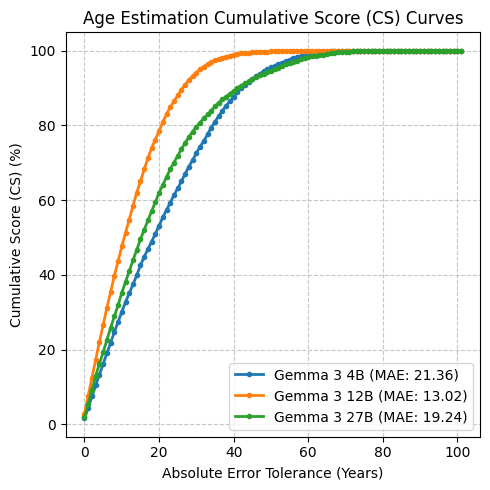

In [15]:
plt.figure(figsize=(5, 5))
max_error_tolerance_plot = 101 # Max error tolerance to plot on x-axis
error_tolerances = np.arange(0, max_error_tolerance_plot + 1)

for model_name, age_metrics in agedb_age_metrics.items():
    raw_errors = np.abs(np.array(age_metrics["errors"]))

    cs_curve_values = []
    for tol in error_tolerances:
        cs_curve_values.append(np.mean(raw_errors <= tol) * 100)
    plt.plot(error_tolerances, cs_curve_values, marker='.', linestyle='-', lw=2, label=f'{model_names[model_name]} (MAE: {age_metrics.get("mae", 0):.2f})')
    
plt.xlabel('Absolute Error Tolerance (Years)')
plt.ylabel('Cumulative Score (CS) (%)')
plt.title('Age Estimation Cumulative Score (CS) Curves')
plt.yticks(np.arange(0, max_error_tolerance_plot, 10))
plt.yticks(np.arange(0, 101, 20))
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Confirming previous comments, these full curves show performance across all tolerances: the steeper the curve, the better the model, meaning that a high percentage of input instances are predicted with less error. Here we can see that the best model is consistently Gemma 3 12 B, thus that fact that having more parameters means better performance dies not hold in this case.

## AgeDB - Gender

In [16]:
agedb_gender_metrics = get_dataset_metrics("agedb-gender")

In [17]:
gender_table_data = []
gender_classes = ["female", "male"]
for model_name, gender_metrics in agedb_gender_metrics.items():
    row = {
        "Model": model_names[model_name],
        "Accuracy (%)": gender_metrics["accuracy"]
    }
    confusion_matrics = gender_metrics["confusion_matrix"]
    y_true = [0] * sum(confusion_matrics[0]) + [1] * sum(confusion_matrics[1])
    y_pred = [0] * confusion_matrics[0][0] + [1] * confusion_matrics[0][1] + [0] * confusion_matrics[1][0] + [1] * confusion_matrics[1][1]
    
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    for i, cls_name in enumerate(gender_classes):
        row[f"F1 ({cls_name.capitalize()})"] = f1[i]
        row[f"Prec ({cls_name.capitalize()})"] = precision[i]
        row[f"Rec ({cls_name.capitalize()})"] = recall[i]
    gender_table_data.append(row)

In [18]:
agedb_gender_performance = pd.DataFrame(gender_table_data).set_index("Model")
print(agedb_gender_performance.to_string(float_format="%.2f"))

             Accuracy (%)  F1 (Female)  Prec (Female)  Rec (Female)  F1 (Male)  Prec (Male)  Rec (Male)
Model                                                                                                  
Gemma 3 4B          97.99         0.98           0.97          0.98       0.98         0.99        0.98
Gemma 3 12B         97.64         0.97           0.97          0.97       0.98         0.98        0.98
Gemma 3 27B         98.00         0.98           0.97          0.98       0.98         0.99        0.98


best model: 98.3 MiVOLO: Multi-input Transformer for Age and Gender Estimation
In the gender prediction task, zer-shot classification with gemma models reaches comparable performances with respect to sota ad-hoc models, which in this case is still MiVOLO as in the age estimantion task, which reaches 98.3. The model with highest accuracy si gemma 3 27B (98), even though it does not seem that having more parameters in this case means better accuracy, since the second best model is gemma 3 4B (97.99), with little difference with respect to the largest model.

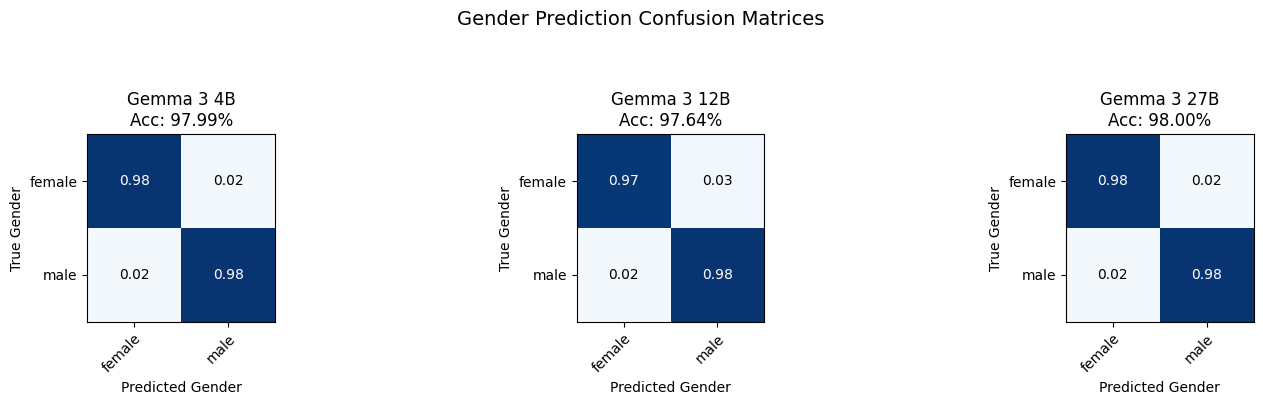

In [19]:
num_models = len(agedb_gender_metrics)
cols = min(3, num_models)
rows = (num_models + cols - 1) // cols
fig_cm, axes_cm = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
axes_cm_flat = axes_cm.flatten()

model_idx = 0
for model_name, gender_metrics in agedb_gender_metrics.items():
    ax = axes_cm_flat[model_idx]
    cm_raw = np.array(gender_metrics["confusion_matrix"])

    cm_normalized = cm_raw.astype('float') / cm_raw.sum(axis=1, keepdims=True)
    cm_normalized = np.nan_to_num(cm_normalized)

    ax.imshow(cm_normalized, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(len(gender_classes)), labels=gender_classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(gender_classes)), labels=gender_classes)
    ax.set_title(f'{model_names[model_name]}\nAcc: {gender_metrics.get("accuracy", 0):.2f}%')
    ax.set_xlabel('Predicted Gender')
    ax.set_ylabel('True Gender')
    
    for i in range(len(gender_classes)):
        for j in range(len(gender_classes)):
            text = ax.text(j, i, f"{cm_normalized[i, j]:.2f}", ha='center', va='center', color='black' if cm_normalized[i, j] < 0.5 else 'white')
    
    model_idx += 1

fig_cm.suptitle('Gender Prediction Confusion Matrices', fontsize=14, y=1.03 if rows > 1 else 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96 if rows > 1 else 0.92]) # Adjust rect to make space for suptitle
plt.show()

Confusion matrices for gender classification are promising, showing a high rate of true positive and true negatives at a low percentage of false positive and false negatives.

## CASIA

In [20]:
casia_metrics = get_dataset_metrics("casia-iris")

In [21]:
casia_df = pd.read_csv("datasets/casia-iris-thousand/iris_thousands.csv")
casia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   Label       20000 non-null  object
 2   ImagePath   20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [22]:
casia_table_data = []
for model_name, metrics in casia_metrics.items():
    casia_table_data.append({
        "Model": model_names[model_name],
        "EER (%)": metrics["eer"] * 100,
        "AUC": metrics["auc"],
        "Acc. @ EER (%)": metrics["accuracy_at_eer"],
        "FAR @ EER (%)": metrics["far_at_eer"],
        "FRR @ EER (%)": metrics["frr_at_eer"],
    })

In [23]:
casia_performance = pd.DataFrame(casia_table_data).set_index("Model")
print(casia_performance.to_string(float_format="%.2f"))

             EER (%)  AUC  Acc. @ EER (%)  FAR @ EER (%)  FRR @ EER (%)
Model                                                                  
Gemma 3 4B     35.05 0.70           64.94          35.00          35.11
Gemma 3 12B    33.28 0.73           66.72          33.24          33.33
Gemma 3 27B    29.94 0.76           70.06          30.15          29.73


Most recent: accuracy: 0.9968 Enhance Biometric Authentication: Integrating Iris and Periocular Verification Through Support Vector Classification, ad hoc system, Given an eye image, our proposed method processes it through verification sub-systems, which are iris verification sub-system and periocular sub-system, and score fusion module. The iris is normalized and passed through a log-Gabor filter for feature extraction, and a binary iris template is quantized from the phase of the complex numbers produced by the log-Gabor filter. The template is compared to stored templates using the Hamming distance. If the score exceeds a set threshold, the system rejects the image. Otherwise, a multi-layer perceptron (MLP) further classifies the template. If the MLP predicts a positive match, the eye image is accepted; otherwise, the result proceeds to a score fusion module.

Our best scoring zoer-shot model is Gemma 3 27B, reaching 70.06 accuracy, which is quite low compared to sota ad-hoc models, reaching 0.99 accuracy. In this case, the approach benefits from having more parameters, as the EER decreases as the number of parameter increases. 

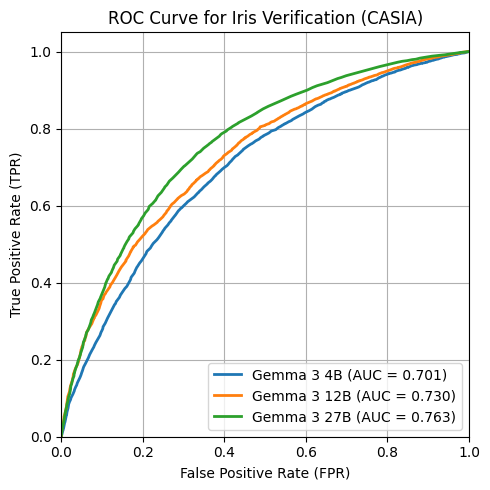

In [36]:
plt.figure(figsize=(5, 5))
for model_name, metrics in casia_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    auc = metrics["auc"]
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[model_name]} (AUC = {auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Iris Verification (CASIA)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Confirming previous comments, ROC curves depicts that performances are goos but still not so near the perfect classifier

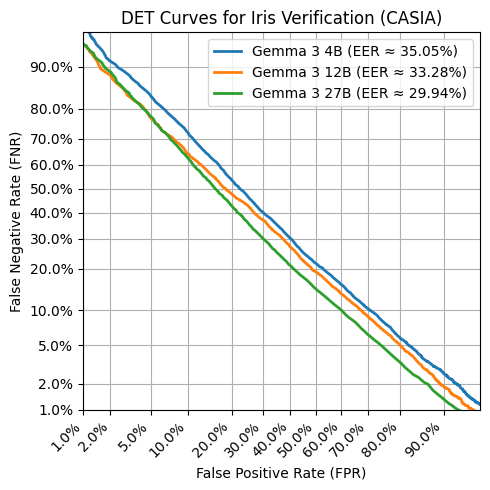

In [37]:
plt.figure(figsize=(5, 5))

# Define tick positions for DET curve (probabilities)
det_ticks_prob = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
det_ticks_nd = norm.ppf(det_ticks_prob) # Convert to Normal Deviate Scale (Z-score)
det_tick_labels = [f"{p*100:.2f}%" if p < 0.01 else f"{p*100:.1f}%" for p in det_ticks_prob]

for model_name, metrics in casia_metrics.items():
    fpr = metrics["fpr"]
    tpr = metrics["tpr"]
    fnr = 1 - tpr

    # Filter out 0s and 1s before ppf, as norm.ppf(0) = -inf, norm.ppf(1) = inf
    # Add a small epsilon to avoid issues with exact 0 or 1
    epsilon = 1e-7
    fpr_clipped = np.clip(fpr, epsilon, 1 - epsilon)
    fnr_clipped = np.clip(fnr, epsilon, 1 - epsilon)
    
    fpr_nd = norm.ppf(fpr_clipped)
    fnr_nd = norm.ppf(fnr_clipped)
    
    plt.plot(fpr_nd, fnr_nd, lw=2, label=f'{model_names[model_name]} (EER ≈ {metrics.get("eer", np.nan)*100:.2f}%)')

plt.xticks(det_ticks_nd, det_tick_labels, rotation=45, ha="right")
plt.yticks(det_ticks_nd, det_tick_labels)
min_val = norm.ppf(0.01) # Smallest value for axis limit
max_val = norm.ppf(0.95)   # Largest value for axis limit (50% is mid-point)
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Negative Rate (FNR)')
plt.title('DET Curves for Iris Verification (CASIA)')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

We have high false positive and false negative rates, but the relationship is linear, meaning that there is no propension of the system towards predicting either false positive or false negatives.

## FVC

In [26]:
fvc_metrics = get_dataset_metrics("fvc")

In [27]:
fvc_table_data = []
for model_name, model_metrics in fvc_metrics.items():
    model_data = {
        "Model": model_names[model_name],
    }
    for year, year_metrics in model_metrics.items():
        dbs_metrics = year_metrics.get("Dbs", {})
        for db_name, db_metrics in dbs_metrics.items():
            model_data[f"{year} {db_name} EER (%)"] = db_metrics["eer"] * 100
            model_data[f"{year} {db_name} AUC"] = db_metrics["auc"]
            model_data[f"{year} {db_name} Acc. @ EER (%)"] = db_metrics["accuracy_at_eer"]
            model_data[f"{year} {db_name} FAR @ EER (%)"] = db_metrics["far_at_eer"]
            model_data[f"{year} {db_name} FRR @ EER (%)"] = db_metrics["frr_at_eer"]
        average_metrics = year_metrics.get("Average", {})
        model_data[f"{year} Average EER (%)"] = average_metrics["eer"] * 100
        model_data[f"{year} Average AUC"] = average_metrics["auc"]
        model_data[f"{year} Average Acc. @ EER (%)"] = average_metrics["accuracy_at_eer"]
        model_data[f"{year} Average FAR @ EER (%)"] = average_metrics["far_at_eer"]
        model_data[f"{year} Average FRR @ EER (%)"] = average_metrics["frr_at_eer"]
    fvc_table_data.append(model_data)

In [28]:
fvc_performance = pd.DataFrame(fvc_table_data).set_index("Model")
print(fvc_performance.to_string(float_format="%.2f"))

             FVC2000 Db1_ EER (%)  FVC2000 Db1_ AUC  FVC2000 Db1_ Acc. @ EER (%)  FVC2000 Db1_ FAR @ EER (%)  FVC2000 Db1_ FRR @ EER (%)  FVC2000 Db2_ EER (%)  FVC2000 Db2_ AUC  FVC2000 Db2_ Acc. @ EER (%)  FVC2000 Db2_ FAR @ EER (%)  FVC2000 Db2_ FRR @ EER (%)  FVC2000 Db3_ EER (%)  FVC2000 Db3_ AUC  FVC2000 Db3_ Acc. @ EER (%)  FVC2000 Db3_ FAR @ EER (%)  FVC2000 Db3_ FRR @ EER (%)  FVC2000 Db4_ EER (%)  FVC2000 Db4_ AUC  FVC2000 Db4_ Acc. @ EER (%)  FVC2000 Db4_ FAR @ EER (%)  FVC2000 Db4_ FRR @ EER (%)  FVC2000 Average EER (%)  FVC2000 Average AUC  FVC2000 Average Acc. @ EER (%)  FVC2000 Average FAR @ EER (%)  FVC2000 Average FRR @ EER (%)  FVC2002 Db1_ EER (%)  FVC2002 Db1_ AUC  FVC2002 Db1_ Acc. @ EER (%)  FVC2002 Db1_ FAR @ EER (%)  FVC2002 Db1_ FRR @ EER (%)  FVC2002 Db2_ EER (%)  FVC2002 Db2_ AUC  FVC2002 Db2_ Acc. @ EER (%)  FVC2002 Db2_ FAR @ EER (%)  FVC2002 Db2_ FRR @ EER (%)  FVC2002 Db3_ EER (%)  FVC2002 Db3_ AUC  FVC2002 Db3_ Acc. @ EER (%)  FVC2002 Db3_ FAR @ EER (%)  

In [29]:
eer_cols = [col for col in fvc_performance.columns if "_ EER" in col]
fvc_performance[eer_cols].mean(axis = 1)

Model
Gemma 3 4B     64.760089
Gemma 3 12B    60.371783
Gemma 3 27B    63.984600
dtype: float64

In [38]:
fvc_performance[eer_cols]

,FVC2000 Db1_ EER (%),FVC2000 Db2_ EER (%),FVC2000 Db3_ EER (%),FVC2000 Db4_ EER (%),FVC2002 Db1_ EER (%),FVC2002 Db2_ EER (%),FVC2002 Db3_ EER (%),FVC2002 Db4_ EER (%),FVC2004 Db1_ EER (%),FVC2004 Db2_ EER (%),FVC2004 Db3_ EER (%),FVC2004 Db4_ EER (%)
Model,,,,,,,,,,,,
Gemma 3 4B,64.81501,71.456245,67.313564,68.457451,64.796339,58.710009,65.091244,65.107478,63.619984,56.952504,70.514996,60.286244
Gemma 3 12B,67.17747,68.408750,64.250094,60.523787,59.701308,60.052488,58.699999,55.894921,46.328748,54.541343,70.567483,58.315003
Gemma 3 27B,68.26809,72.253520,72.765428,66.373143,63.519364,58.888320,63.417346,61.863617,47.634924,58.684285,73.614670,60.532497


In [30]:
average_columns = [col for col in fvc_performance.columns if "Average" in col and "Acc." in col]
print(fvc_performance[average_columns].to_string(float_format="%.2f"))

             FVC2000 Average Acc. @ EER (%)  FVC2002 Average Acc. @ EER (%)  FVC2004 Average Acc. @ EER (%)
Model                                                                                                      
Gemma 3 4B                            32.00                           36.57                           37.16
Gemma 3 12B                           34.90                           41.41                           42.56
Gemma 3 27B                           30.07                           38.23                           39.80


The best performing system at the moment has an EER of 0.014% and it is from a private company. Their methods uses features from deep learning networks (no longer description)., results on ongoing FVC.

Gemma 3 models do not perform well on fingerprint verification, with the best model (Gemma 3 12B) having an average EER of 60.37%. This performance is not comparable at all with sota systems, and this could be the case also because fingerprints can be precisely described and analysed by well-established algorithms which do not require the use of machine learning methods. Unfortunately, being the best sota system from a private company, we cannot discuss and compare their approach with our zero-shot classificaition.

## CelebA

In [31]:
celeba_metrics = get_dataset_metrics("celeba")

In [32]:
celeba_table_data = []
for model_name, model_metrics in celeba_metrics.items():
    model_data = {
        "Model": model_names[model_name],
    }
    for attribute_name, attribute_metrics in model_metrics.items():
        if attribute_name == "overall":
            continue
        model_data[f"{attribute_name} EER (%)"] = attribute_metrics["eer"] * 100
        model_data[f"{attribute_name} AUC"] = attribute_metrics["auc"]
        model_data[f"{attribute_name} Acc. @ EER (%)"] = attribute_metrics["accuracy_at_eer"]
        model_data[f"{attribute_name} FAR @ EER (%)"] = attribute_metrics["far_at_eer"]
        model_data[f"{attribute_name} FRR @ EER (%)"] = attribute_metrics["frr_at_eer"]
    model_data["Average EER (%)"] = model_metrics["overall"]["eer"] * 100
    model_data["Average AUC"] = model_metrics["overall"]["auc"]
    model_data["Average Acc. @ EER (%)"] = model_metrics["overall"]["accuracy_at_eer"]
    model_data["Average FAR @ EER (%)"] = model_metrics["overall"]["far_at_eer"]
    model_data["Average FRR @ EER (%)"] = model_metrics["overall"]["frr_at_eer"]
    celeba_table_data.append(model_data)

In [33]:
celeba_performance = pd.DataFrame(celeba_table_data).set_index("Model")
print(celeba_performance.to_string(float_format="%.2f"))

             5_o_Clock_Shadow EER (%)  5_o_Clock_Shadow AUC  5_o_Clock_Shadow Acc. @ EER (%)  5_o_Clock_Shadow FAR @ EER (%)  5_o_Clock_Shadow FRR @ EER (%)  Arched_Eyebrows EER (%)  Arched_Eyebrows AUC  Arched_Eyebrows Acc. @ EER (%)  Arched_Eyebrows FAR @ EER (%)  Arched_Eyebrows FRR @ EER (%)  Attractive EER (%)  Attractive AUC  Attractive Acc. @ EER (%)  Attractive FAR @ EER (%)  Attractive FRR @ EER (%)  Bags_Under_Eyes EER (%)  Bags_Under_Eyes AUC  Bags_Under_Eyes Acc. @ EER (%)  Bags_Under_Eyes FAR @ EER (%)  Bags_Under_Eyes FRR @ EER (%)  Bald EER (%)  Bald AUC  Bald Acc. @ EER (%)  Bald FAR @ EER (%)  Bald FRR @ EER (%)  Bangs EER (%)  Bangs AUC  Bangs Acc. @ EER (%)  Bangs FAR @ EER (%)  Bangs FRR @ EER (%)  Big_Lips EER (%)  Big_Lips AUC  Big_Lips Acc. @ EER (%)  Big_Lips FAR @ EER (%)  Big_Lips FRR @ EER (%)  Big_Nose EER (%)  Big_Nose AUC  Big_Nose Acc. @ EER (%)  Big_Nose FAR @ EER (%)  Big_Nose FRR @ EER (%)  Black_Hair EER (%)  Black_Hair AUC  Black_Hair Acc. @ EER (%) 

In [34]:
average_columns = [col for col in celeba_performance.columns if "Average" in col]
print(celeba_performance[average_columns].to_string(float_format="%.2f"))

             Average EER (%)  Average AUC  Average Acc. @ EER (%)  Average FAR @ EER (%)  Average FRR @ EER (%)
Model                                                                                                          
Gemma 3 4B             23.93         0.84                   76.07                  23.94                  23.93
Gemma 3 12B            24.43         0.84                   75.56                  24.44                  24.43
Gemma 3 27B            23.06         0.87                   76.94                  23.07                  23.06


In [35]:
acc_columns = [col for col in celeba_performance.columns if "Acc." in col]
print(celeba_performance[acc_columns].to_string(float_format="%.2f"))

             5_o_Clock_Shadow Acc. @ EER (%)  Arched_Eyebrows Acc. @ EER (%)  Attractive Acc. @ EER (%)  Bags_Under_Eyes Acc. @ EER (%)  Bald Acc. @ EER (%)  Bangs Acc. @ EER (%)  Big_Lips Acc. @ EER (%)  Big_Nose Acc. @ EER (%)  Black_Hair Acc. @ EER (%)  Blond_Hair Acc. @ EER (%)  Blurry Acc. @ EER (%)  Brown_Hair Acc. @ EER (%)  Bushy_Eyebrows Acc. @ EER (%)  Chubby Acc. @ EER (%)  Double_Chin Acc. @ EER (%)  Eyeglasses Acc. @ EER (%)  Goatee Acc. @ EER (%)  Gray_Hair Acc. @ EER (%)  Heavy_Makeup Acc. @ EER (%)  High_Cheekbones Acc. @ EER (%)  Male Acc. @ EER (%)  Mouth_Slightly_Open Acc. @ EER (%)  Mustache Acc. @ EER (%)  Narrow_Eyes Acc. @ EER (%)  No_Beard Acc. @ EER (%)  Oval_Face Acc. @ EER (%)  Pale_Skin Acc. @ EER (%)  Pointy_Nose Acc. @ EER (%)  Receding_Hairline Acc. @ EER (%)  Rosy_Cheeks Acc. @ EER (%)  Sideburns Acc. @ EER (%)  Smiling Acc. @ EER (%)  Straight_Hair Acc. @ EER (%)  Wavy_Hair Acc. @ EER (%)  Wearing_Earrings Acc. @ EER (%)  Wearing_Hat Acc. @ EER (%)  Wea

We compare these results with the best model proposed in the dataset paper deep learning face attributes in the wild, which is build on CNN similar to AlexNet.

Overall Gemma 3 has worse but comparable performances wrt the model used in the paper. the features that it detects the best are the male feature and the bald feature (also in the best model in the paper), while the feature that it detects the worst are the narrow eyes and the oval face features, (for the best model in the paper are oval face and big lips). 
it does not seem that having more model parameters has a linear relation with the model performance.